# LANL Host Dataset

### Article : https://www.worldscientific.com/doi/pdf/10.1142/9781786345646_001

Notes:

"The events from the host logs included in the data set are all related to authentication and process activity on each machine"

### Pour obtenir le dataset:
1- https://csr.lanl.gov/data/2017/#citing : donner mail, obtenir le lien

2- https://csr.lanl.gov/data-fence/... 10 chiffres.../... token... iXYXXbqw15UugRnZALCZ2Y8dvEk=... /unified-host-network-dataset-2017/wls.html pour avoir l'index avec tous les fichiers compressés

3- download : for i in $(seq -w 1 90); do wget -c https://csr.lanl.gov/data-fence/...10 chiffres.../...token.../unified-host-network-dataset-2017/wls/wls_day-$i.bz2; done

4- decompress, as required : bzip2 -dk filename.bz2

### EventID : 

EventID         Description

Authentication events

4768            Kerberos authentication ticket was requested (TGT)

4769            Kerberos service ticket was requested (TGS)

4770            Kerberos service ticket was renewed

4774            An account was mapped for logon

4776            Domain controller attempted to validate credentials

4624            An account successfully logged on, see Logon Types

4625            An account failed to logon, see Logon Types

4634            An account was logged off, see Logon Types

4647            User initiated logoff

4648            A logon was attempted using explicit credentials

4672            Special privileges assigned to a new logon

4800            The workstation was locked

4801            The workstation was unlocked

4802            The screensaver was invoked

4803            The screensaver was dismissed

Process events

4688            Process start

4689            Process end

System events

4608            Windows is starting up

4609            Windows is shutting down

1100            Event logging service has shut down (often recorded instead of EventID 4609)


Detailed description : - EventID : https://learn.microsoft.com/en-us/windows-server/identity/ad-ds/plan/appendix-l--events-to-monitor


### Logon Types for EventIDs: 4624, 4625 and 4634

LogonTypes (EventIDs: 4624, 4625 and 4634)

2 — Interactive

3 — Network

4 — Batch

12 — Cached Remote-Interactive

5 — Service

9 — New Credentials

7 — Unlock

10 — Remote Interactive

8 — Network Clear Text 11 — Cached Interactive

0 — Used only by the system account

### Host Log Fields

. Time: The epoch time of the event in seconds.

• EventID: Four digit integer corresponding to the event id of the record.

• LogHost: The hostname of the computer that the event was recorded on.In the case of directed authentication events, the LogHost will correspond to the computer that the authentication event is terminating at (destination computer).

• LogonType: Integer corresponding to the type of logon, see Table 2.

• LogonTypeDescription: Description of the LogonType, see Table 2.

• UserName: The user account initiating the event. If the user ends in $, then it corresponds to a computer account for the specified computer.

• DomainName: Domain name of UserName.

• LogonID: A semi-unique (unique between current sessions and LogHost)number that identifies the logon session just initiated. Any events logged subsequently during this logon session should report the same LogonID through to the logoff event.

• SubjectUserName: For authentication mapping events, the user account specified by this field is mapping to the user account in UserName.

• SubjectDomainName: Domain name of SubjectUserName.

• SubjectLogonID: See LogonID.

• Status: Status of the authentication request. “0 × 0” means success otherwise failure; failure codes for the appropriate EventID are available online.f

• Source: For authentication events, this will correspond to the the computer where the authentication originated (source computer), if it is a local logon event then this will be the same as the LogHost.

• ServiceName: The account name of the computer or service the user is requesting the ticket for.

• Destination: This is the server the mapped credential is accessing. This may indicate the local computer when starting another process with new account credentials on a local computer.

• AuthenticationPackage: The type of authentication occurring including Negotiate, Kerberos, NTLM plus a few more.

• FailureReason: The reason for a failed logon.

• ProcessName: The process executable name, for authentication events this is the process that processed the authentication event. ProcessNames may include the file type extensions (i.e., exe).

• ProcessID: A semi-unique (unique between currently running processes AND LogHost) value that identifies the process. ProcessID allows you to correlate other events logged in association with the same process through to the process end.

• ParentProcessName: The process executable that started the new process. ParentProcessNames often do not have file extensions like ProcessName but can be compared by removing file extensions from the name.

• ParentProcessID: Identifies the exact process that started the new process. Look for a preceding event 4688 with a ProcessID that matches this ParentProcessID.

### Bibliothèques

In [1]:
import json
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
from keras import ops
from keras import layers

from sklearn.preprocessing import StandardScaler

# from sklearn.svm import OneClassSVM

# from sklearn.decomposition import PCA
# from sklearn.decomposition import KernelPCA

from sklearn.neighbors import KernelDensity
# from sklearn.model_selection import GridSearchCV

# from sklearn.mixture import BayesianGaussianMixture

2024-08-02 18:22:12.028453: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-02 18:22:12.056755: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-02 18:22:12.138002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 18:22:12.256973: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 18:22:12.295171: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-02 18:22:12.397668: I tensorflow/core/platform/cpu_feature_gu

### Calcul du nombre de lignes des deux premiers fichiers wls_day-01.bz2 et wls_day-02.bz2 une fois décompressés : plus de 50 millions de lignes par fichier

In [2]:
# affiche le nombre de lignes de chaque fichier

def get_lines_number(filepath):
    """retourne le nombre de lignes d'un fichier *.json

    Args:
        filename (_type_): full path filename
    """
    
    with open(filepath) as f:
        ctr_lignes = sum(1 for line in f)
        
    return ctr_lignes

In [3]:
dirpath = '/home/benjamin/Folders_Python/Cyber/data/LALN_processed/'
liste_fichiers = [ 'wls_day-01.json', 'wls_day-02.json']

for filename in liste_fichiers:
    filepath = dirpath + filename

    # print(f'{filename} contient {get_lines_number(filepath)} lignes')

### Framework pour le traitement des données

In [4]:
# STRUCTURE DES DONNEES
# ---------------------

# il y a 90 fichiers wls_day-nn.bz2, un pour chaque jour d'enregistrement

# chaque fichier wls_day-nn.bz2 peut se décompresser :
# - via la ligne de commande : bzip2 -dk filename.bz2 (préserve le fichier compressé original)
# - via la bibliothèque python : https://docs.python.org/3/library/bz2.html

# un fichier décompressé est un fichier *.json au format lignes : chaque ligne du fichier est un objet JSON distinct

# chaque objet JSON est un objet à un seul niveau, avec un maximum de 21 paires (key, value)

# ALGORITHME
# ----------

# on va lire les objets JSON un par un (ligne par ligne) et traiter les données séquentiellement.
# chaque champ est managé par un dictionnaire, où :
# - les keys sont les valeurs possibles, déjà vues, du champ
# - les values sont une liste de deux int : 1/ une valeur pour encoder categorical, 2/ un compteur

# PROCESS :
# ---------

# loop sur objets JSON :
# - concaténation de UserName et DomaineName, pour donner un UserNameDomainName qui identifie le user account. Drop UserName, DomaineName
# - pour chacun des 20 champs :
# -- checke si présent dans le JSON object
# ---- si non présent : valeur = -1 (correspond à NaN)
# ---- si présent : regarde dans le dictionnaire du champ
# ------ si existe déjà : retourne valeur, incrémente compteur
# ------ si n'existe pas : crée key, crée nouvelle valeur (= max anciennes + 1), met compteur à 1

In [5]:
# liste des champs à traiter

list_fields = [
    'Time', # int64
    'EventID', # int64
    'LogHost', # object
    'LogonType', # float64, corresponding to the type of logon, see Table 2.
    'LogonTypeDescription', # object Description of the LogonType, see Table 2.
    'UserName', # object - The user account initiating the event. If the user ends in $, then it corresponds to a computer account for the specified computer.
    'DomainName', # object - Domain name of UserName.
    'LogonID', #: object. A semi-unique (unique between current sessions and LogHost)number that identifies the logon session just initiated. Any events logged subsequently during this logon session should report the same LogonID through to the logoff event.
    'SubjectUserName', # object. For authentication mapping events, the user account specified by this field is mapping to the user account in UserName.
    'SubjectDomainName', # object - Domain name of SubjectUserName.
    'SubjectLogonID', # object - See LogonID.
    'Status', # object - Status of the authentication request. “0 × 0” means success otherwise failure; failure codes for the appropriate EventID are available online.f
    'Source', # object - For authentication events, this will correspond to the the computer where the authentication originated (source computer), if it is a local logon event then this will be the same as the LogHost.
    'ServiceName', # object - The account name of the computer or service the user is requesting the ticket for.
    'Destination', # object - This is the server the mapped credential is accessing. This may indicate the local computer when starting another process with new account credentials on a local computer.
    'AuthenticationPackage', # object - The type of authentication occurring including Negotiate, Kerberos, NTLM plus a few more.
    'FailureReason', # object - The reason for a failed logon.
    'ProcessName', # object - The process executable name, for authentication events this is the process that processed the authentication event. ProcessNames may include the file type extensions (i.e., exe).
    'ProcessID', # object - A semi-unique (unique between currently running processes AND LogHost) value that identifies the process. ProcessID allows you to correlate other events logged in association with the same process through to the process end.
    'ParentProcessName', # object - The process executable that started the new process. ParentProcessNames often do not have file extensions like ProcessName but can be compared by removing file extensions from the name.
    'ParentProcessID', # object - Identifies the exact process that started the new process. Look for a preceding event 4688 with a ProcessID that matches this ParentProcessID.
    'UserNameDomainName', # object - n'existe pas dans les fichiers, concaténation de UserName et DomainName 
] 

In [6]:
class FieldRecord():
    """classe pour gérer les champs. Les valeurs sont apprises au fil de l'eau, et une valeur 'categorical' est associée à chaque valeur unique.
    
    - list_values (type list) est la liste des valeurs apprises, que peut prendre le champ. Valeur initiale : [None]
    - list_counts (type list) est la liste des nombres d'occurences de la valeur correpondante, à date. Valeur initiale : [0]
    - nom : le nom du champ
    - des méthodes utilitaires
    """
    
    def __init__(self, nom):
        self.nom = nom # nom du champ...
        self.list_values = [None] # valeurs possibles que peut prendre le champ. On initialise None à la valeur catgéorical 0
        self.list_counts = [0] # nombres d'occurences constatées de la valeur correspondante
           
    def __str__(self):
        ctr = sum(x for x in self.list_counts)
        msg = f'Objet FieldRecord pour champ {self.nom} \n - connaît {len(self.list_values)} valeurs distinctes \n - a vu {ctr} champs au total'
        return msg
    
    def __repr__(self):
        ctr = sum(x for x in self.list_counts)
        msg = f'Objet FieldRecord pour champ {self.nom} \n - connaît {len(self.list_values)} valeurs distinctes \n - a vu {ctr} champs au total'
        return msg
    
    def get_field_categorical_value(self, val):
        """retourne l'int pour encodage catégorical du champ passé en argument
        NB : les NaN ou None sont encodés à 0 par défaut. (cf constructeur)

        Args:
            val (int ou string): valeur extraite de la ligne JSON
        """
        if val not in self.list_values:
            # si la valeur est nouvelle, rajoute à la liste des valeurs connues
            self.list_values.append(val) 
            self.list_counts.append(1)
            cat_val = self.list_values.index(val)
        else:
            # si la valeur est déjà connue, retourne son index dans la liste comme categorical value et incrémente le compteur
            cat_val = self.list_values.index(val) 
            self.list_counts[cat_val] += 1
            
        return cat_val

In [7]:
# créé les 21+1 objets Field Records

def get_fresh_dico():
    
    dico = {
        field : FieldRecord(field) for field in list_fields
    }
    return dico

In [8]:
dico = get_fresh_dico()

In [9]:
def display_stats_dico(dico=dico):
    """affiche statistiques descriptives du grand répertoire des champs traités
    """

    output = ""
    
    for field in list_fields:
        ctr = sum(x for x in dico[field].list_counts)
        output = output + f"Champ {field}: valeurs distinctes apprises {len(dico[field].list_values)}, valeurs vues : {ctr}\n"
        
    return output

In [10]:
print(display_stats_dico(dico))

Champ Time: valeurs distinctes apprises 1, valeurs vues : 0
Champ EventID: valeurs distinctes apprises 1, valeurs vues : 0
Champ LogHost: valeurs distinctes apprises 1, valeurs vues : 0
Champ LogonType: valeurs distinctes apprises 1, valeurs vues : 0
Champ LogonTypeDescription: valeurs distinctes apprises 1, valeurs vues : 0
Champ UserName: valeurs distinctes apprises 1, valeurs vues : 0
Champ DomainName: valeurs distinctes apprises 1, valeurs vues : 0
Champ LogonID: valeurs distinctes apprises 1, valeurs vues : 0
Champ SubjectUserName: valeurs distinctes apprises 1, valeurs vues : 0
Champ SubjectDomainName: valeurs distinctes apprises 1, valeurs vues : 0
Champ SubjectLogonID: valeurs distinctes apprises 1, valeurs vues : 0
Champ Status: valeurs distinctes apprises 1, valeurs vues : 0
Champ Source: valeurs distinctes apprises 1, valeurs vues : 0
Champ ServiceName: valeurs distinctes apprises 1, valeurs vues : 0
Champ Destination: valeurs distinctes apprises 1, valeurs vues : 0
Champ Au

In [11]:
# ---------------------------------
# -------------- Test -------------
# ---------------------------------

dirpath = '/home/benjamin/Folders_Python/Cyber/data/LALN_processed/'
filename = 'wls_day-02.json'
filepath = dirpath + filename

N_SAMPLES = 20

# 1ere DataFrame : valeurs brutes
dict_for_df_raw = {
    field : [] for field in list_fields
}

# 2e DataFrame : valeurs nettes
dict_for_df = {
    field : [] for field in list_fields
}

dico = get_fresh_dico()

with open(filepath, 'r') as f:
    for i in range(N_SAMPLES):
        # lit lignes du fichier une à une et convertit en dict Python
        line = f.readline()
        obj_json = json.loads(line)
        # calcule à la main le UserNameDoaminName
        obj_json['UserNameDomainName'] = obj_json.get('UserName') + obj_json.get('DomainName')
        # print(obj_json)
        # trouve la valeur de chaque champ (éventuellement None) et traduit en categorical value suivant dictionnaire dico
        for field in list_fields:
            # print(f'{field} = {obj_json.get(field,None)}')
            # print(dico[field])
            val = obj_json.get(field, None)
            dict_for_df_raw[field].append(val)
            dict_for_df[field].append(dico[field].get_field_categorical_value(val))
            
        msg = display_stats_dico(dico)
        
        # if i%10==0:
        #     print(msg + '\r')

In [12]:
df_raw = pd.DataFrame(dict_for_df_raw)

df_raw

,Time,EventID,LogHost,LogonType,LogonTypeDescription,UserName,DomainName,LogonID,SubjectUserName,SubjectDomainName,...,Source,ServiceName,Destination,AuthenticationPackage,FailureReason,ProcessName,ProcessID,ParentProcessName,ParentProcessID,UserNameDomainName
0,86400,4688,Comp883524,NaN,None,Comp883524$,Domain001,0x3e7,None,None,...,None,None,None,None,None,wmiprvse.exe,0x1db4,svchost,0x35c,Comp883524$Domain001
1,86400,4688,Comp836249,NaN,None,User805641,Domain001,0x45a5847,None,None,...,None,None,None,None,None,Proc542756.exe,0x3314,Proc028501,0x3a8c,User805641Domain001
2,86400,4688,Comp397468,NaN,None,Comp397468$,Domain001,0x3e7,None,None,...,None,None,None,None,None,svchost.exe,0xc770,services,0x2b8,Comp397468$Domain001
3,86400,4672,Comp916004,NaN,None,Comp916004$,Domain001,0x32bba0c8,None,None,...,None,None,None,None,None,None,None,None,None,Comp916004$Domain001
4,86400,4624,Comp916004,3.0,Network,Comp916004$,Domain001,0x32bba0c8,None,None,...,Comp916004,None,None,Kerberos,None,None,None,None,None,Comp916004$Domain001
5,86400,4688,Comp836249,NaN,None,Comp836249$,Domain001,0x3e7,None,None,...,None,None,None,None,None,conhost.exe,0x17b8,csrss,0x1c0,Comp836249$Domain001
6,86400,4688,Comp000116,NaN,None,Comp000116$,Domain001,0x3e7,None,None,...,None,None,None,None,None,rundll32.exe,0x13ee0,services,0x2e0,Comp000116$Domain001
7,86400,4634,Comp373973,3.0,Network,Comp373973$,Domain001,0x13ff5c02,None,None,...,None,None,None,None,None,None,None,None,None,Comp373973$Domain001
8,86400,4688,Comp763951,NaN,None,Comp763951$,Domain001,0x3e7,None,None,...,None,None,None,None,None,Proc461749.exe,0x190c,Proc461749,0x91c,Comp763951$Domain001
9,86400,4688,EnterpriseAppServer,NaN,None,local service,nt authority,0x3e5,None,None,...,None,None,None,None,None,Proc965106.exe,0x15c4,Proc126308,0x7d8,local servicent authority


In [13]:
df = pd.DataFrame(dict_for_df)

df

,Time,EventID,LogHost,LogonType,LogonTypeDescription,UserName,DomainName,LogonID,SubjectUserName,SubjectDomainName,...,Source,ServiceName,Destination,AuthenticationPackage,FailureReason,ProcessName,ProcessID,ParentProcessName,ParentProcessID,UserNameDomainName
0,1,1,1,0,0,1,1,1,0,0,...,0,0,0,0,0,1,1,1,1,1
1,1,1,2,0,0,2,1,2,0,0,...,0,0,0,0,0,2,2,2,2,2
2,1,1,3,0,0,3,1,1,0,0,...,0,0,0,0,0,3,3,3,3,3
3,1,2,4,0,0,4,1,3,0,0,...,0,0,0,0,0,0,0,0,0,4
4,1,3,4,1,1,4,1,3,0,0,...,1,0,0,1,0,0,0,0,0,4
5,1,1,2,0,0,5,1,1,0,0,...,0,0,0,0,0,4,4,4,4,5
6,1,1,5,0,0,6,1,1,0,0,...,0,0,0,0,0,5,5,3,5,6
7,1,4,6,1,1,7,1,4,0,0,...,0,0,0,0,0,0,0,0,0,7
8,1,1,7,0,0,8,1,1,0,0,...,0,0,0,0,0,6,6,5,6,8
9,1,1,8,0,0,9,2,5,0,0,...,0,0,0,0,0,7,7,6,7,9


In [14]:
df.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
Time,20.0,1.00,0.000000,1.0,1.00,1.0,1.00,1.0
EventID,20.0,1.60,0.940325,1.0,1.00,1.0,2.00,4.0
LogHost,20.0,6.90,3.552612,1.0,4.00,7.5,10.00,12.0
LogonType,20.0,0.30,0.656947,0.0,0.00,0.0,0.00,2.0
LogonTypeDescription,20.0,0.30,0.656947,0.0,0.00,0.0,0.00,2.0
UserName,20.0,8.35,4.498830,1.0,4.00,8.5,13.00,15.0
DomainName,20.0,1.25,0.444262,1.0,1.00,1.0,1.25,2.0
LogonID,20.0,1.60,1.187656,1.0,1.00,1.0,1.25,5.0
SubjectUserName,20.0,0.00,0.000000,0.0,0.00,0.0,0.00,0.0
SubjectDomainName,20.0,0.00,0.000000,0.0,0.00,0.0,0.00,0.0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Time                   20 non-null     int64
 1   EventID                20 non-null     int64
 2   LogHost                20 non-null     int64
 3   LogonType              20 non-null     int64
 4   LogonTypeDescription   20 non-null     int64
 5   UserName               20 non-null     int64
 6   DomainName             20 non-null     int64
 7   LogonID                20 non-null     int64
 8   SubjectUserName        20 non-null     int64
 9   SubjectDomainName      20 non-null     int64
 10  SubjectLogonID         20 non-null     int64
 11  Status                 20 non-null     int64
 12  Source                 20 non-null     int64
 13  ServiceName            20 non-null     int64
 14  Destination            20 non-null     int64
 15  AuthenticationPackage  20 non-null     int

In [16]:
# -----------------------------------------------
# -- PARKING LOT : code pour itérateur ----------

# class LinesBatchIterator():
#     """iterateur pour retourner des batchs de taille BATCH_SIZE depuis le fichier json FILEPATH
#     """
    
#     def __init__(self, filepath, batch_size=None):
#         self.filepath = filepath
#         if batch_size == None:
#             self.batch_size = 10 # taille de batch par défaut pour debug
#         else:
#             self.batch_size = batch_size
            
#     def __iter__(self):
#         return self
    
#     def __next__(self):
#         """retourne le prochain batch de taille 'batch_size'
#         """
        
#         # 1ere DataFrame : valeurs brutes - POUR DEBUG
#         dict_for_df_raw = {
#             field : [] for field in list_fields
#             }
        
#         dict_for_df = {
#             field : [] for field in list_fields
#             }
        
#         with open(filepath) as f:
#             for i in range(self.batch_size):
#                 # lit lignes du fichier une à une et convertit en dict Python
#                 # print(i)
#                 line = f.readline()
#                 # si fin du fichier, on arrête
#                 if line=="":
#                     raise StopIteration
#                 # sinon, on traite
#                 obj_json = json.loads(line)
#                 # calcule à la main le UserNameDoaminName
#                 obj_json['UserNameDomainName'] = obj_json.get('UserName') + obj_json.get('DomainName')
#                 # trouve la valeur de chaque champ (éventuellement None) et traduit en categorical value suivant dictionnaire dico
#                 for field in list_fields:
#                     val = obj_json.get(field, None)
#                     dict_for_df_raw[field].append(val)
#                     dict_for_df[field].append(dico[field].get_field_categorical_value(val))
#             df = pd.DataFrame(dict_for_df)
#             df_raw = pd.DataFrame(dict_for_df_raw)
            
#         return df_raw, df
    
#     def __repr__(self):
#         msg = f"objet batch iterator, fichier = {self.filepath}, batch_size={self.batch_size}"
#         return msg

In [17]:
# dirpath = '/home/benjamin/Folders_Python/Cyber/data/LALN_processed/'
# filename = 'wls_day-02.json'
# filepath = dirpath + filename

# line_iterator = LinesBatchIterator(filepath=filepath)

In [18]:
# print(line_iterator)

In [19]:
# df_raw, df = next(line_iterator)

# df_raw

In [20]:
# df_raw, df = next(line_iterator)

# df_raw

### EDA sur un GROS fichier

In [21]:
# choisit le fichier

dirpath = '/home/benjamin/Folders_Python/Cyber/data/LALN_processed/'
filename = 'wls_day-01_subset_10000.json'

filepath = dirpath + filename

In [22]:
# Initialisations

# 1ere DataFrame : valeurs brutes
dict_for_df_raw = {
    field : [] for field in list_fields
}

# 2e DataFrame : valeurs nettes
dict_for_df = {
    field : [] for field in list_fields
}

dico = get_fresh_dico()

In [23]:
%%time

print(f"Processe {filename}\n")

with open(file=filepath) as f:
    ctr_lines = 0
    line = f.readline()
    while line != "":
        ctr_lines += 1
        print(f"traite ligne {ctr_lines}", end="\r", flush=True)
        obj_json = json.loads(line)
        # calcule à la main le UserNameDomainName
        obj_json['UserNameDomainName'] = obj_json.get('UserName') + obj_json.get('DomainName')
        # print(obj_json)
        # trouve la valeur de chaque champ (éventuellement None) et traduit en categorical value suivant dictionnaire dico
        for field in list_fields:
            # print(f'{field} = {obj_json.get(field,None)}')
            # print(dico[field])
            val = obj_json.get(field, None)
            dict_for_df_raw[field].append(val)
            dict_for_df[field].append(dico[field].get_field_categorical_value(val))
        line = f.readline()
    print(f"\n")
    
    # df_raw = pd.DataFrame(dict_for_df_raw)
    # df = pd.DataFrame(dict_for_df)

Processe wls_day-01_subset_10000.json

traite ligne 10000

CPU times: user 53 s, sys: 7.02 s, total: 1min
Wall time: 1min 20s


In [24]:
print(display_stats_dico(dico))

Champ Time: valeurs distinctes apprises 3, valeurs vues : 10000
Champ EventID: valeurs distinctes apprises 9, valeurs vues : 10000
Champ LogHost: valeurs distinctes apprises 2730, valeurs vues : 10000
Champ LogonType: valeurs distinctes apprises 5, valeurs vues : 10000
Champ LogonTypeDescription: valeurs distinctes apprises 5, valeurs vues : 10000
Champ UserName: valeurs distinctes apprises 103, valeurs vues : 10000
Champ DomainName: valeurs distinctes apprises 5, valeurs vues : 10000
Champ LogonID: valeurs distinctes apprises 422, valeurs vues : 10000
Champ SubjectUserName: valeurs distinctes apprises 11, valeurs vues : 10000
Champ SubjectDomainName: valeurs distinctes apprises 3, valeurs vues : 10000
Champ SubjectLogonID: valeurs distinctes apprises 15, valeurs vues : 10000
Champ Status: valeurs distinctes apprises 5, valeurs vues : 10000
Champ Source: valeurs distinctes apprises 57, valeurs vues : 10000
Champ ServiceName: valeurs distinctes apprises 18, valeurs vues : 10000
Champ De

In [25]:
df = pd.DataFrame(dict_for_df)

In [26]:
df.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
Time,10000.0,1.4970,0.500016,1.0,1.0,1.0,2.0,2.0
EventID,10000.0,1.6933,0.978944,1.0,1.0,2.0,2.0,8.0
LogHost,10000.0,1238.0280,791.483749,1.0,531.0,1256.0,1904.0,2729.0
LogonType,10000.0,0.5588,0.608917,0.0,0.0,0.0,1.0,4.0
LogonTypeDescription,10000.0,0.5588,0.608917,0.0,0.0,0.0,1.0,4.0
UserName,10000.0,3.5188,11.456438,1.0,1.0,1.0,1.0,102.0
DomainName,10000.0,1.1250,0.353818,1.0,1.0,1.0,1.0,4.0
LogonID,10000.0,18.6576,66.746839,0.0,1.0,1.0,1.0,421.0
SubjectUserName,10000.0,0.0388,0.460126,0.0,0.0,0.0,0.0,10.0
SubjectDomainName,10000.0,0.0129,0.113732,0.0,0.0,0.0,0.0,2.0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Time                   10000 non-null  int64
 1   EventID                10000 non-null  int64
 2   LogHost                10000 non-null  int64
 3   LogonType              10000 non-null  int64
 4   LogonTypeDescription   10000 non-null  int64
 5   UserName               10000 non-null  int64
 6   DomainName             10000 non-null  int64
 7   LogonID                10000 non-null  int64
 8   SubjectUserName        10000 non-null  int64
 9   SubjectDomainName      10000 non-null  int64
 10  SubjectLogonID         10000 non-null  int64
 11  Status                 10000 non-null  int64
 12  Source                 10000 non-null  int64
 13  ServiceName            10000 non-null  int64
 14  Destination            10000 non-null  int64
 15  AuthenticationPackage  10000 non-null

In [28]:
df

,Time,EventID,LogHost,LogonType,LogonTypeDescription,UserName,DomainName,LogonID,SubjectUserName,SubjectDomainName,...,Source,ServiceName,Destination,AuthenticationPackage,FailureReason,ProcessName,ProcessID,ParentProcessName,ParentProcessID,UserNameDomainName
0,1,1,1,1,1,1,1,1,0,0,...,0,0,0,1,0,1,1,0,0,1
1,1,2,1,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,2,2,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,1,3,1,1,1,1,1,0,0,...,0,0,0,1,0,1,2,0,0,1
4,1,1,4,2,2,2,2,2,0,0,...,1,0,0,2,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,1,2729,1,1,1,1,1,0,0,...,0,0,0,1,0,1,27,0,0,1
9996,2,2,2729,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
9997,2,3,5,2,2,3,2,421,0,0,...,0,0,0,0,0,0,0,0,0,3
9998,2,4,5,0,0,3,2,379,1,1,...,0,0,1,0,0,2,180,0,0,3


### Training VAE continu (inspiré tuto F Chollet Keras)

In [11]:
# Sampling layer

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the latent variable encoding an input."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(42)

    def call(self, inputs):
        z_mean, z_log_var = inputs  # log var plutôt que l'écart type
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        # reparametrisation trick from original article Kingma and Welling, “Auto-Encoding Variational Bayes”, ICLR 2014
        scale = 0.25 # manage l'amplitude du bruit dans le reparametrisation trick pour éviter le posterior collapse
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon * scale

In [12]:
input_dim = len(list_fields)  # nombre de features
output_dim = input_dim
latent_dim = 2  # choix pour affichage 2D

In [13]:
# Encoder

encoder_inputs = keras.Input(shape=(input_dim,))

# basic MLP
x = layers.Dense(128, activation="relu")(encoder_inputs)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)

# output mean et log_var de la gaussienne
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# sample de la gaussienne inférée par le MLP
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      2,944 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         66 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         66 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,412 (52.39 KB)

 Trainable params: 13,412 (52.39 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Decoder

# input : vecteur de l'espace latent
latent_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(32, activation="relu")(latent_inputs)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)

decoder_outputs = layers.Dense(output_dim)(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 22)             │         2,838 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,366 (52.21 KB)

 Trainable params: 13,366 (52.21 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Classe VAE

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        # encodeur vers l'espace latent
        self.encoder = encoder
        # décodeur depuis l'espace latent
        self.decoder = decoder
        # losses
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        # une étape de forward pass, avec différentiation des losses
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)  # forward pass de l'encodeur
            reconstruction = self.decoder(z)  # veceteur reconstruit depuis la variable latent samplée
            # 1ere loss : erreur reconstruction entre la data et la reconstruction
            reconstruction_loss = ops.mean(keras.losses.mean_squared_error(data, reconstruction)),  # norme L2 pour calculer l'erreur de reconstruction
            # 2e loss : KL entre le posterior z|x appris par l'encodeur et N(0,I) cible
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            # loss totale (ELBO)
            total_loss = reconstruction_loss + kl_loss
            
        # calcul des gradients
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [16]:
# Display projection de 'data' dans le latent space

def plot_label_clusters(vae, data, titre=None): #, labels):
    """Affiche en 2D la projection de data dans l'espace latent de vae

    Args:
        vae (_type_): modèle VAE
        labels (_type_): np.array 2D des points à afficher

    Returns:
        fig, ax
    """
    
    LIM = 3.0
    BANDWIDTH = 0.20 # taille du noyau gaussien pour KDE
    NUM = 50 # nombre points pour affichage contour
    
    fig, ax = plt.subplots(figsize=(6,6))
    
    # calculate projection of data on the latent space
    z_mean, _, _ = vae.encoder.predict(data, verbose=0)

    # fit un KDE pour afficher un contour
    rng = np.random.RandomState(42)
    kde = KernelDensity(kernel='gaussian',bandwidth=BANDWIDTH).fit(z_mean)
    
    # affiche plt.contour
    levels = [ 0.10, 0.25, 0.50, 0.75, 0.90 ]
    x = np.linspace( -LIM, +LIM, num=NUM)
    y = np.linspace( -LIM, +LIM, num=NUM)
    X, Y = np.meshgrid(x, y) # X a shape NUm x NUM
    Z = np.zeros(shape=(NUM,NUM)) # ny,nx
    for j in range(NUM): # ny
        for k in range(NUM): # nx
            xc = X[j,k]
            yc = Y[j,k]
            point = np.array([xc,yc]).reshape(-1,2)
            Z[j,k] = np.exp(kde.score_samples(point))  # repasse aux probas depuis le log retourné par score_samples
            # print(point)
    cs = ax.contour(X,Y,Z,levels)
    ax.clabel(cs, inline=True, fontsize=10)  # affiche log probas
    
    # trace nuage de points projetés dans l'espace latent
    ax.scatter(z_mean[:, 0], z_mean[:, 1], marker='.') 
    ax.set_xlabel("z[0]")
    ax.set_xlim(left=-LIM, right=+LIM)
    ax.set_ylabel("z[1]")
    ax.set_ylim(bottom=-LIM, top=+LIM)
    
    if titre==None:
        titre = 'Espace latent VAE'
    ax.set_title(titre)
    ax.grid(True)
        
    return fig, ax

In [17]:
# instancie modèle, prêt au training

vae = VAE(encoder, decoder)

vae.compile(optimizer=keras.optimizers.Adam())

In [18]:
# Paramètres pour training séquentiel

# ---- batch -----
BATCH_SIZE = 2000 # batch de lignes que l'on va lire par training

# ---- choisit le fichier
dirpath = '/home/benjamin/Folders_Python/Cyber/data/LALN_processed/'
filename = 'wls_day-01_subset_100000.json'
filepath = dirpath + filename

# ---- outputs modèle
list_outputs = ['kl_loss', 'loss', 'reconstruction_loss']

# --- pour faire une video
video_rep = '/home/benjamin/Folders_Python/Cyber/data/jpg_for_videos/'

Processe wls_day-01_subset_100000.json

Process batch 1 de 2000 lignes


traite ligne 2000 du batch 1
entraîne VAE sur batch 1 --------------
kl_loss : 0.14
loss : 0.36
reconstruction_loss : 0.22


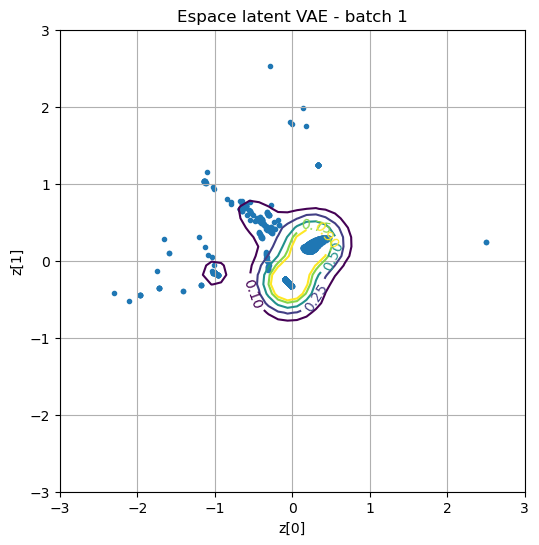

Process batch 2 de 2000 lignes
traite ligne 2000 du batch 2
entraîne VAE sur batch 2 --------------
kl_loss : 0.13
loss : 0.37
reconstruction_loss : 0.25


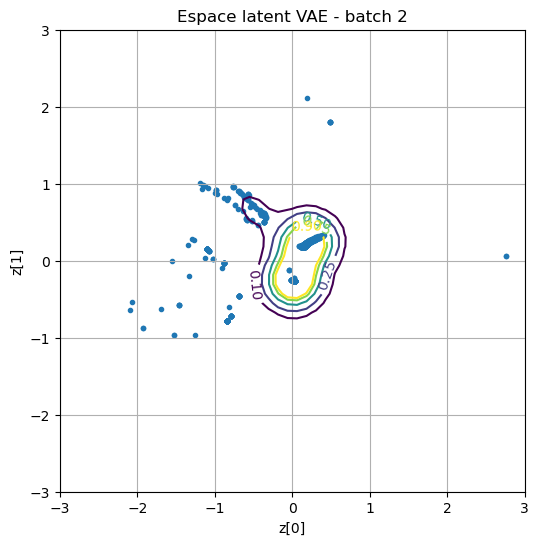

Process batch 3 de 2000 lignes
traite ligne 2000 du batch 3
entraîne VAE sur batch 3 --------------
kl_loss : 0.15
loss : 0.38
reconstruction_loss : 0.23


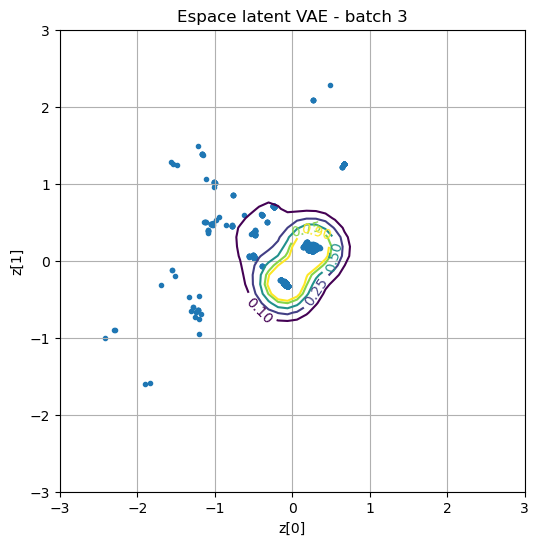

Process batch 4 de 2000 lignes
traite ligne 2000 du batch 4
entraîne VAE sur batch 4 --------------
kl_loss : 0.14
loss : 0.31
reconstruction_loss : 0.17


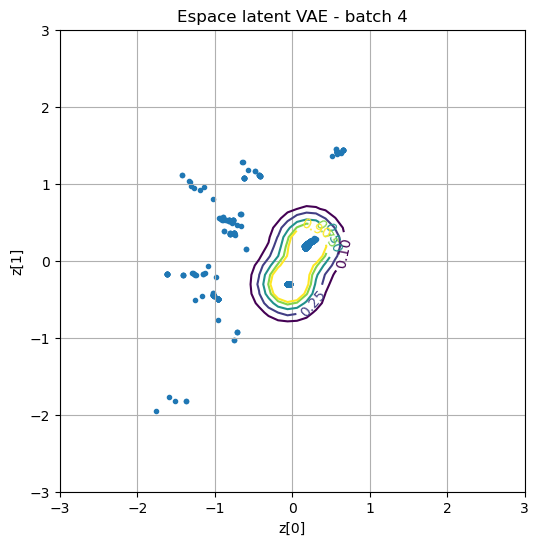

Process batch 5 de 2000 lignes
traite ligne 2000 du batch 5
entraîne VAE sur batch 5 --------------
kl_loss : 0.13
loss : 0.29
reconstruction_loss : 0.16


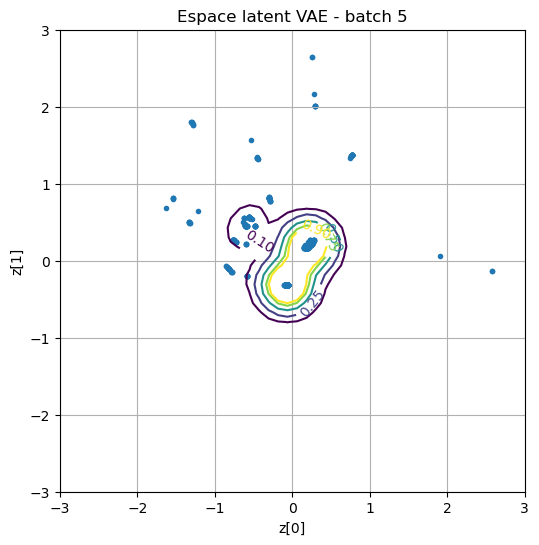

Process batch 6 de 2000 lignes
traite ligne 2000 du batch 6
entraîne VAE sur batch 6 --------------
kl_loss : 0.14
loss : 0.30
reconstruction_loss : 0.16


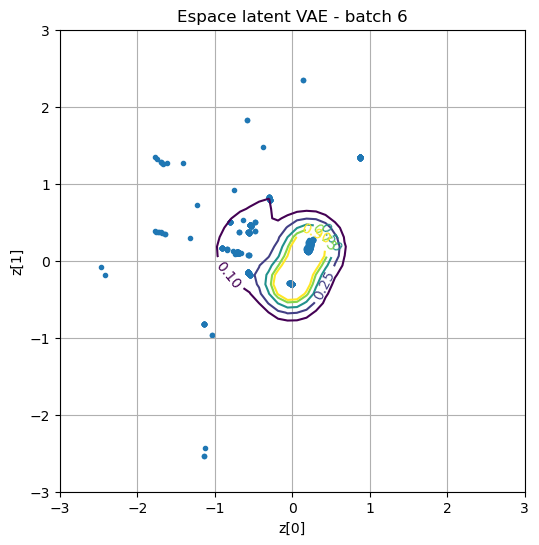

Process batch 7 de 2000 lignes
traite ligne 2000 du batch 7
entraîne VAE sur batch 7 --------------
kl_loss : 0.15
loss : 0.35
reconstruction_loss : 0.20


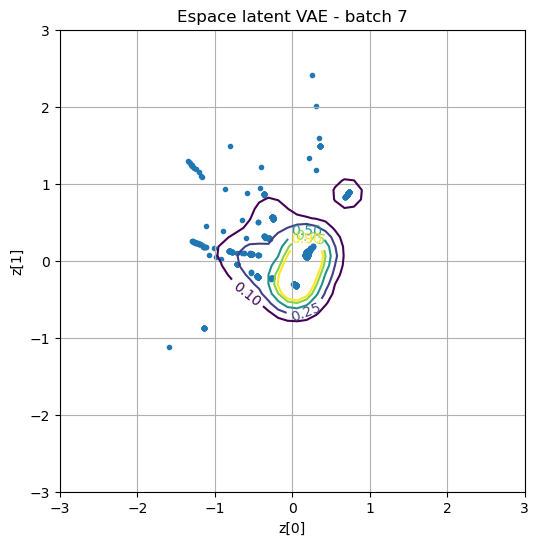

Process batch 8 de 2000 lignes
traite ligne 2000 du batch 8
entraîne VAE sur batch 8 --------------
kl_loss : 0.15
loss : 0.49
reconstruction_loss : 0.34


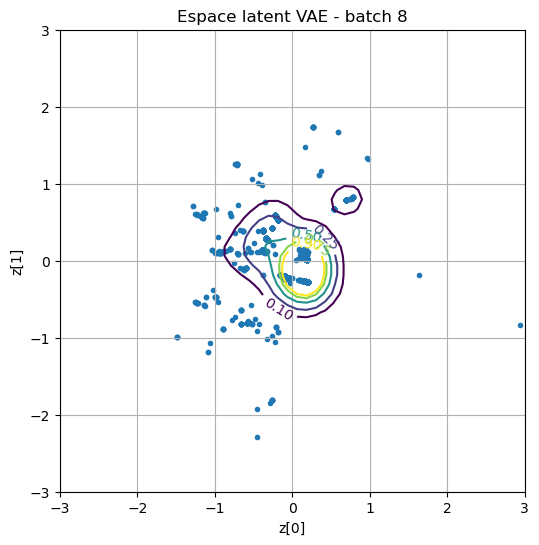

Process batch 9 de 2000 lignes
traite ligne 2000 du batch 9
entraîne VAE sur batch 9 --------------
kl_loss : 0.18
loss : 0.46
reconstruction_loss : 0.28


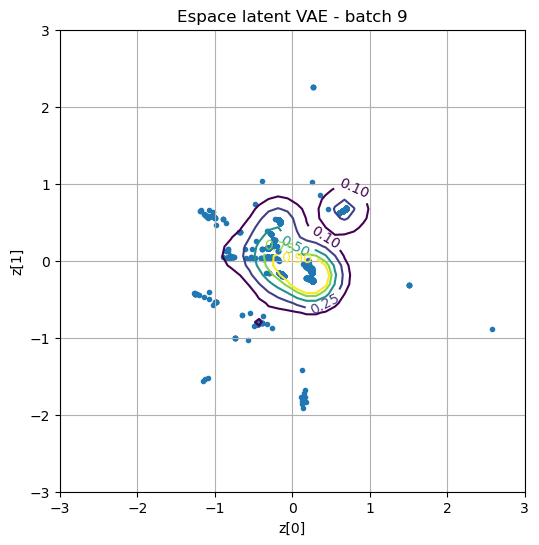

Process batch 10 de 2000 lignes
traite ligne 2000 du batch 10
entraîne VAE sur batch 10 --------------
kl_loss : 0.18
loss : 0.55
reconstruction_loss : 0.37


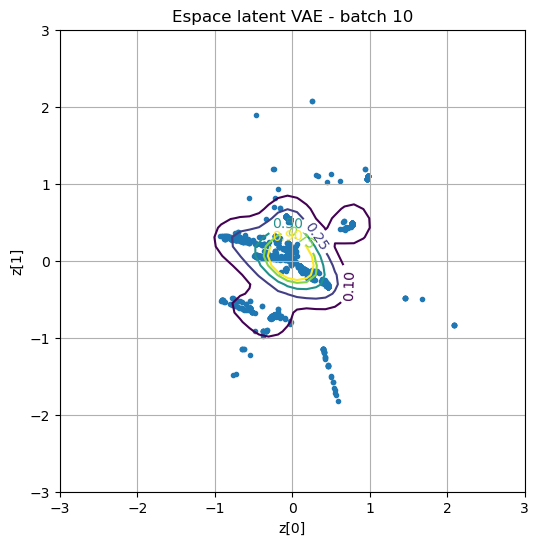

Process batch 11 de 2000 lignes
traite ligne 2000 du batch 11
entraîne VAE sur batch 11 --------------
kl_loss : 0.14
loss : 0.53
reconstruction_loss : 0.39


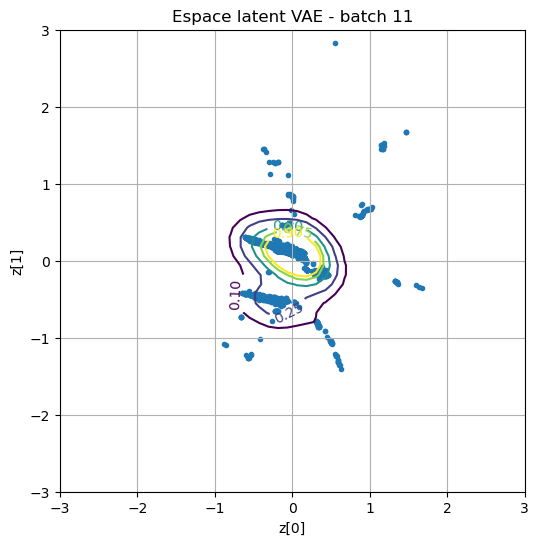

Process batch 12 de 2000 lignes
traite ligne 2000 du batch 12
entraîne VAE sur batch 12 --------------
kl_loss : 0.15
loss : 0.55
reconstruction_loss : 0.39


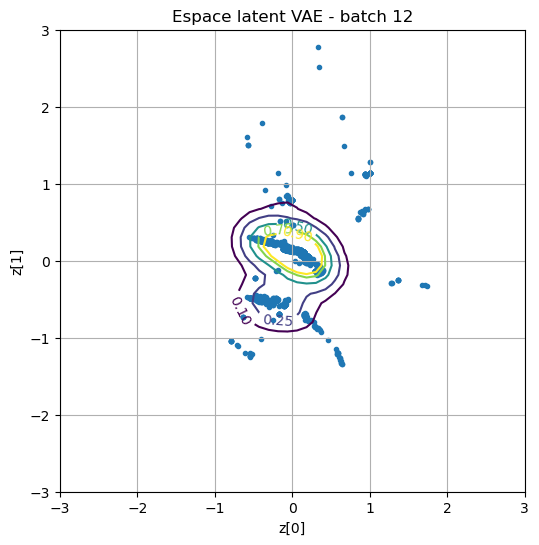

Process batch 13 de 2000 lignes
traite ligne 2000 du batch 13
entraîne VAE sur batch 13 --------------
kl_loss : 0.16
loss : 0.54
reconstruction_loss : 0.39


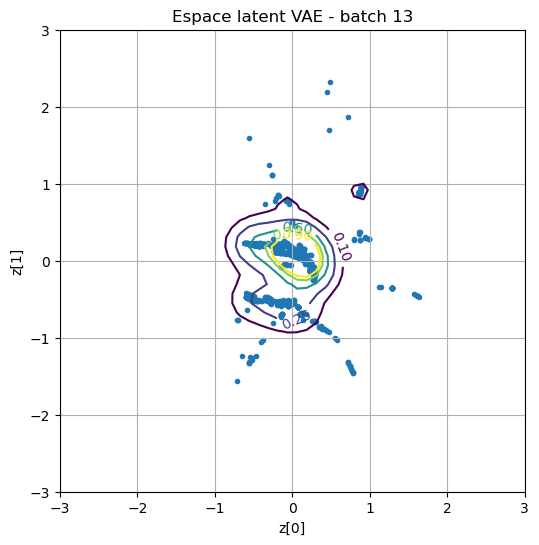

Process batch 14 de 2000 lignes
traite ligne 2000 du batch 14
entraîne VAE sur batch 14 --------------
kl_loss : 0.16
loss : 0.51
reconstruction_loss : 0.36


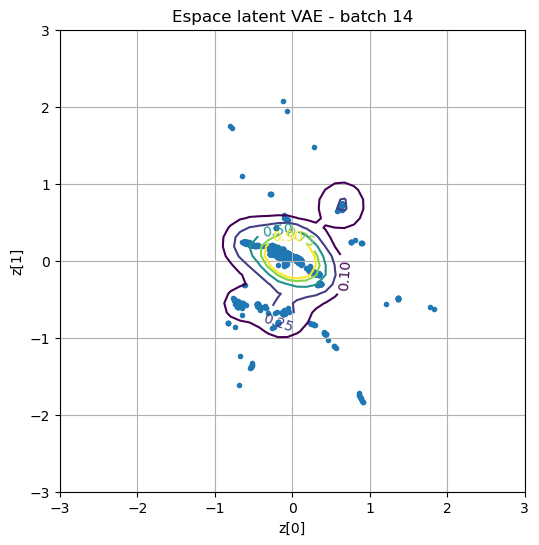

Process batch 15 de 2000 lignes
traite ligne 2000 du batch 15
entraîne VAE sur batch 15 --------------
kl_loss : 0.13
loss : 0.50
reconstruction_loss : 0.36


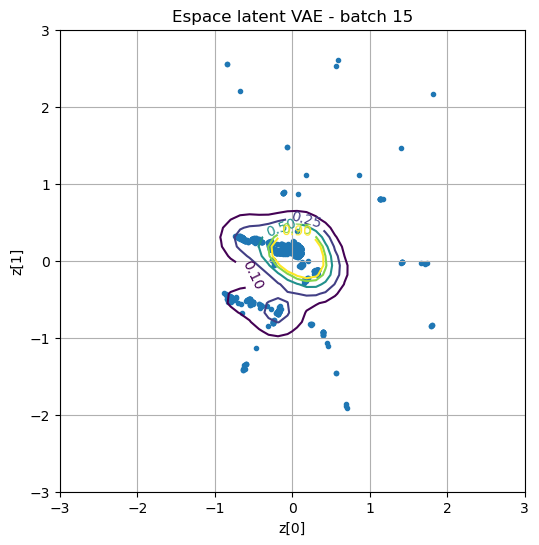

Process batch 16 de 2000 lignes
traite ligne 2000 du batch 16
entraîne VAE sur batch 16 --------------
kl_loss : 0.13
loss : 0.50
reconstruction_loss : 0.37


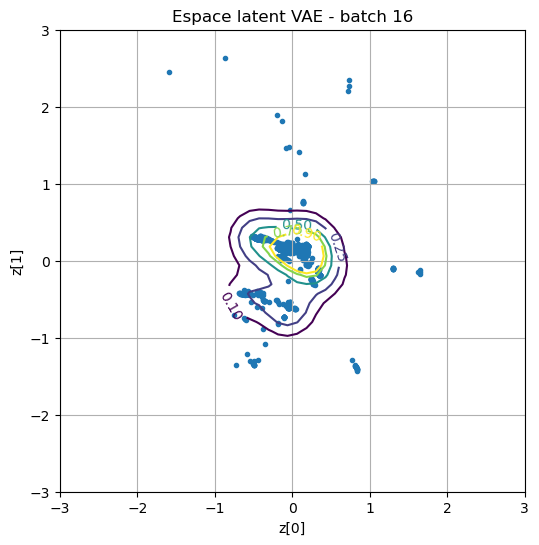

Process batch 17 de 2000 lignes
traite ligne 2000 du batch 17
entraîne VAE sur batch 17 --------------
kl_loss : 0.13
loss : 0.48
reconstruction_loss : 0.35


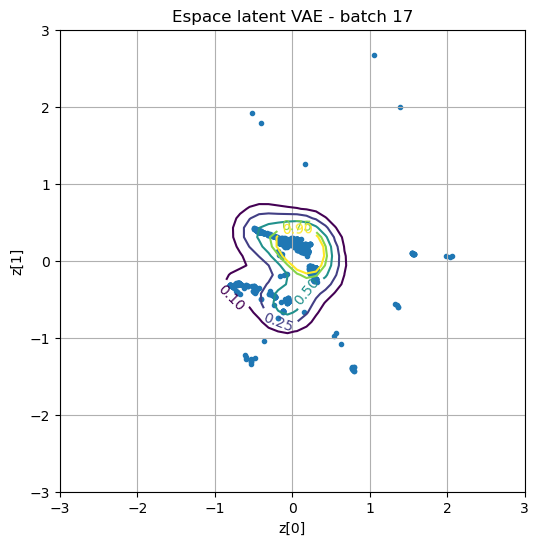

Process batch 18 de 2000 lignes
traite ligne 2000 du batch 18
entraîne VAE sur batch 18 --------------
kl_loss : 0.13
loss : 0.49
reconstruction_loss : 0.36


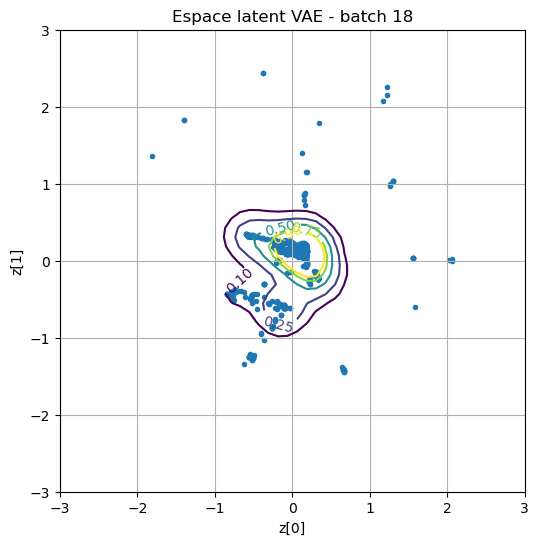

Process batch 19 de 2000 lignes
traite ligne 2000 du batch 19
entraîne VAE sur batch 19 --------------
kl_loss : 0.13
loss : 0.50
reconstruction_loss : 0.36


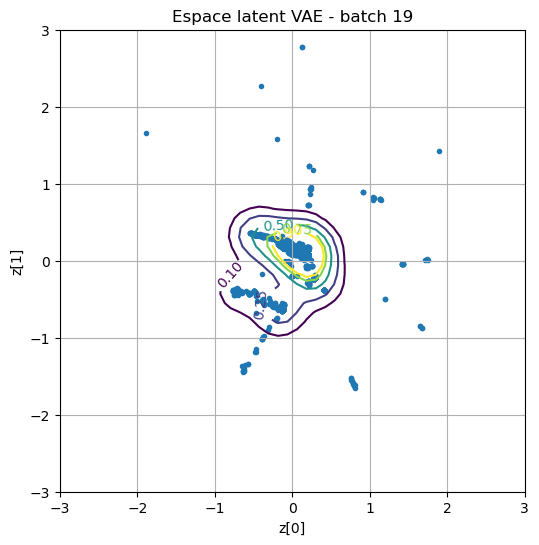

Process batch 20 de 2000 lignes
traite ligne 2000 du batch 20
entraîne VAE sur batch 20 --------------
kl_loss : 0.14
loss : 0.49
reconstruction_loss : 0.35


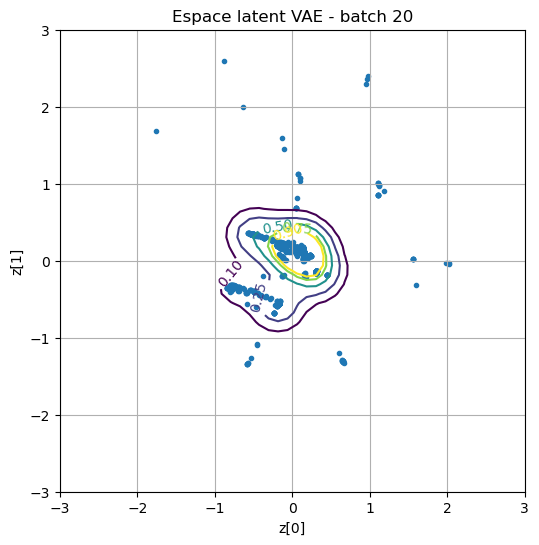

Process batch 21 de 2000 lignes
traite ligne 2000 du batch 21
entraîne VAE sur batch 21 --------------
kl_loss : 0.15
loss : 0.51
reconstruction_loss : 0.36


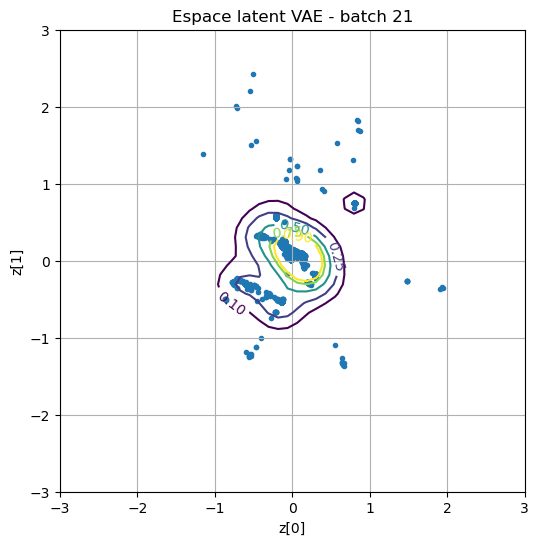

Process batch 22 de 2000 lignes
traite ligne 2000 du batch 22
entraîne VAE sur batch 22 --------------
kl_loss : 0.14
loss : 0.48
reconstruction_loss : 0.34


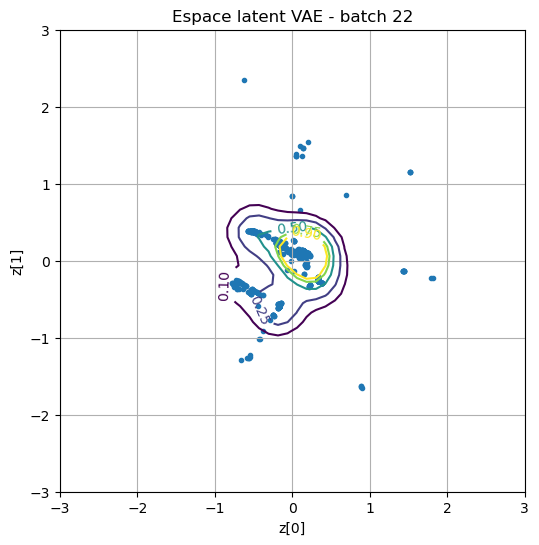

Process batch 23 de 2000 lignes
traite ligne 2000 du batch 23
entraîne VAE sur batch 23 --------------
kl_loss : 0.13
loss : 0.48
reconstruction_loss : 0.34


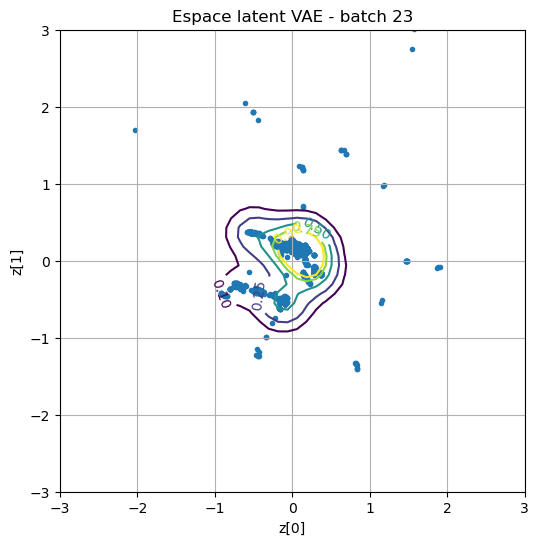

Process batch 24 de 2000 lignes
traite ligne 2000 du batch 24
entraîne VAE sur batch 24 --------------
kl_loss : 0.14
loss : 0.49
reconstruction_loss : 0.35


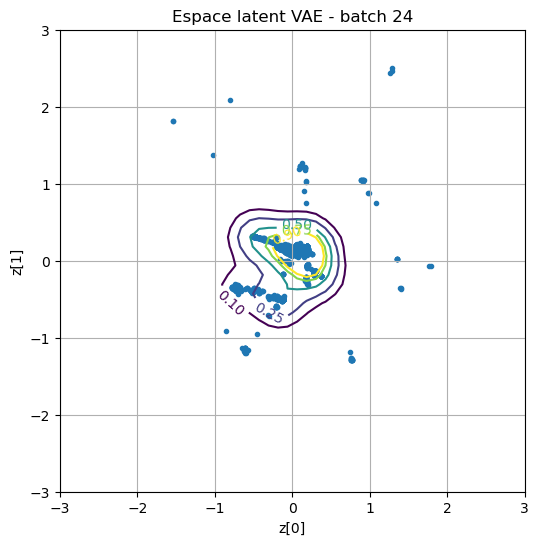

Process batch 25 de 2000 lignes
traite ligne 2000 du batch 25
entraîne VAE sur batch 25 --------------
kl_loss : 0.12
loss : 0.48
reconstruction_loss : 0.36


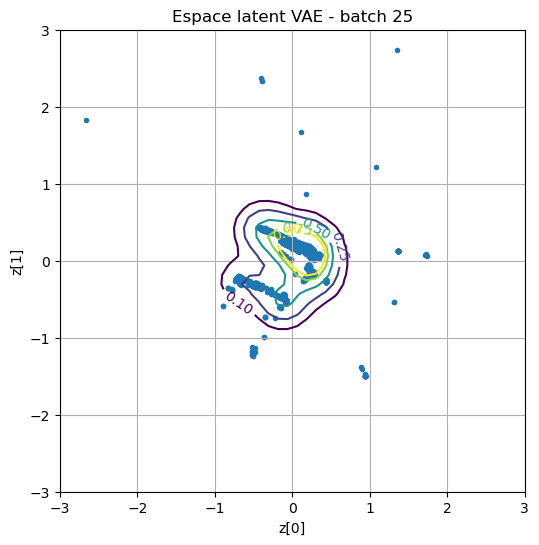

Process batch 26 de 2000 lignes
traite ligne 2000 du batch 26
entraîne VAE sur batch 26 --------------
kl_loss : 0.12
loss : 0.48
reconstruction_loss : 0.35


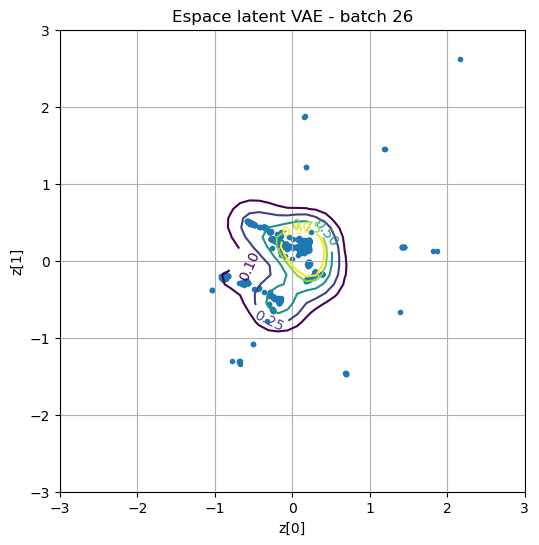

Process batch 27 de 2000 lignes
traite ligne 2000 du batch 27
entraîne VAE sur batch 27 --------------
kl_loss : 0.12
loss : 0.48
reconstruction_loss : 0.36


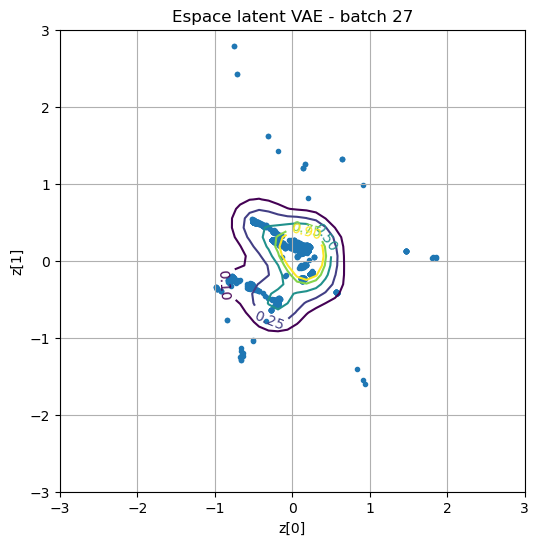

Process batch 28 de 2000 lignes
traite ligne 2000 du batch 28
entraîne VAE sur batch 28 --------------
kl_loss : 0.12
loss : 0.46
reconstruction_loss : 0.33


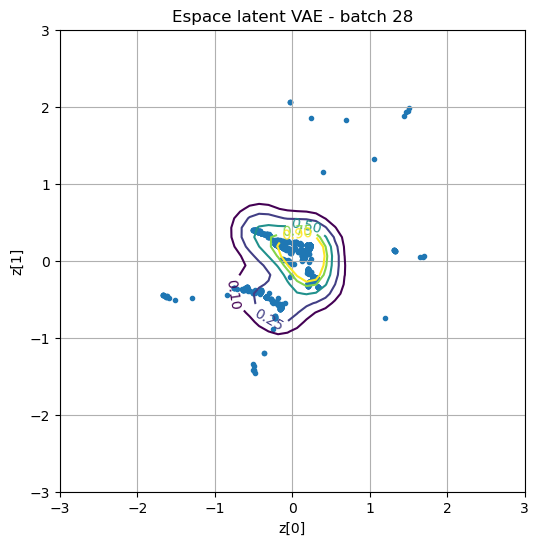

Process batch 29 de 2000 lignes
traite ligne 2000 du batch 29
entraîne VAE sur batch 29 --------------
kl_loss : 0.13
loss : 0.48
reconstruction_loss : 0.34


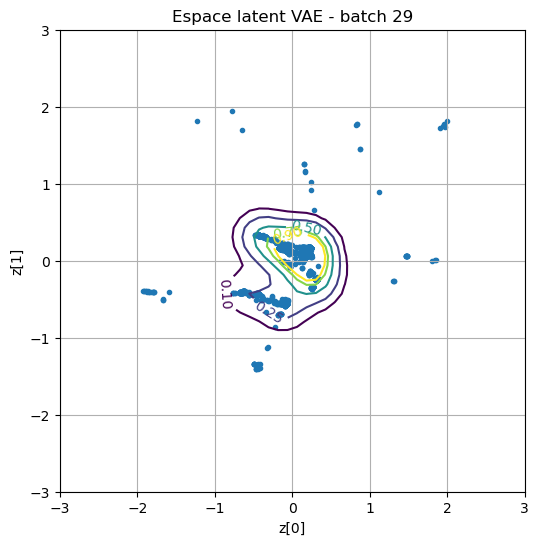

Process batch 30 de 2000 lignes
traite ligne 2000 du batch 30
entraîne VAE sur batch 30 --------------
kl_loss : 0.13
loss : 0.50
reconstruction_loss : 0.37


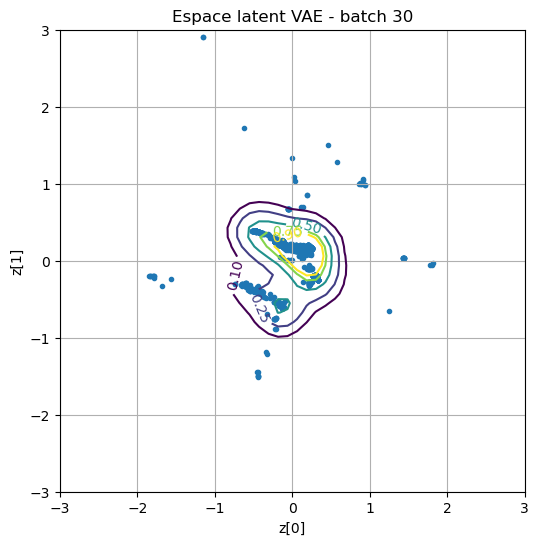

Process batch 31 de 2000 lignes
traite ligne 2000 du batch 31
entraîne VAE sur batch 31 --------------
kl_loss : 0.14
loss : 0.50
reconstruction_loss : 0.37


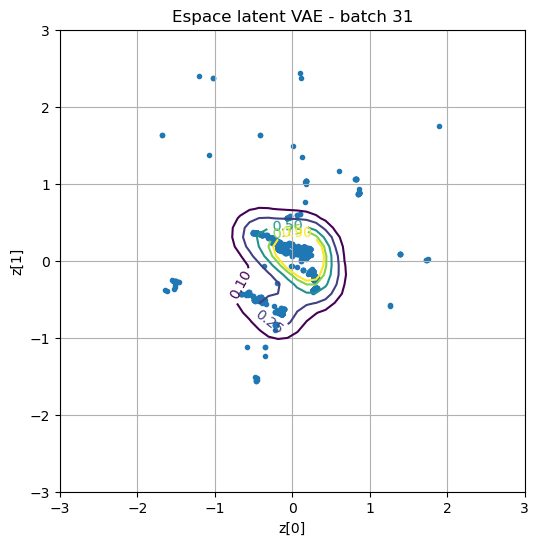

Process batch 32 de 2000 lignes
traite ligne 2000 du batch 32
entraîne VAE sur batch 32 --------------
kl_loss : 0.13
loss : 0.48
reconstruction_loss : 0.35


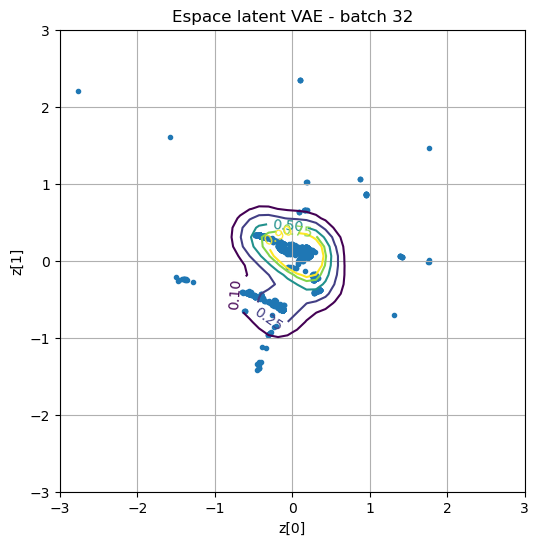

Process batch 33 de 2000 lignes
traite ligne 2000 du batch 33
entraîne VAE sur batch 33 --------------
kl_loss : 0.14
loss : 0.52
reconstruction_loss : 0.38


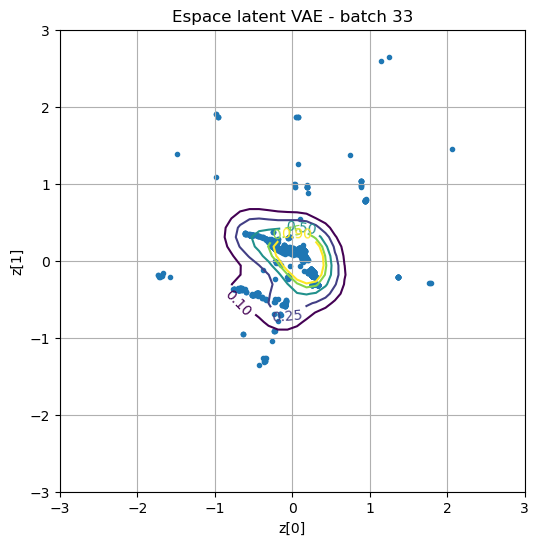

Process batch 34 de 2000 lignes
traite ligne 2000 du batch 34
entraîne VAE sur batch 34 --------------
kl_loss : 0.14
loss : 0.49
reconstruction_loss : 0.35


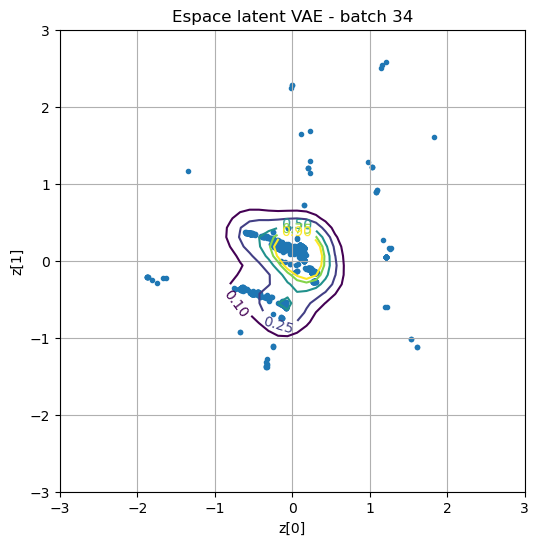

Process batch 35 de 2000 lignes
traite ligne 2000 du batch 35
entraîne VAE sur batch 35 --------------
kl_loss : 0.14
loss : 0.49
reconstruction_loss : 0.35


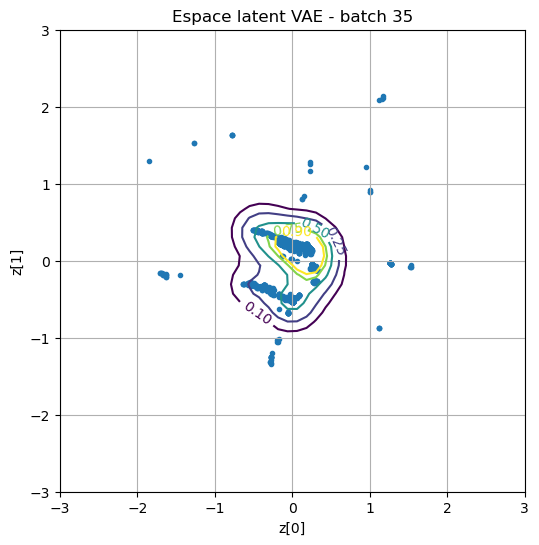

Process batch 36 de 2000 lignes
traite ligne 2000 du batch 36
entraîne VAE sur batch 36 --------------
kl_loss : 0.13
loss : 0.50
reconstruction_loss : 0.37


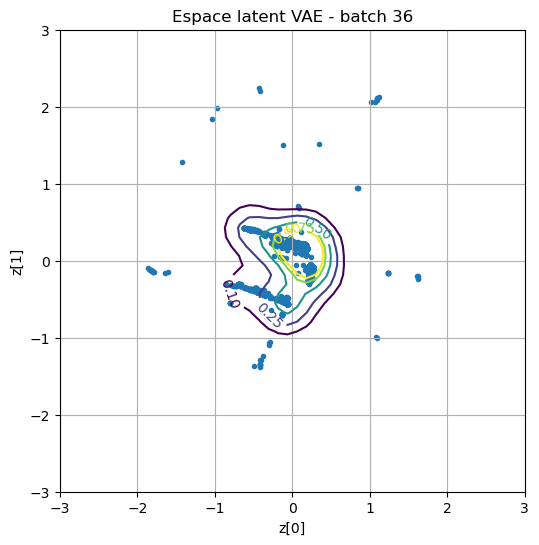

Process batch 37 de 2000 lignes
traite ligne 2000 du batch 37
entraîne VAE sur batch 37 --------------
kl_loss : 0.13
loss : 0.46
reconstruction_loss : 0.32


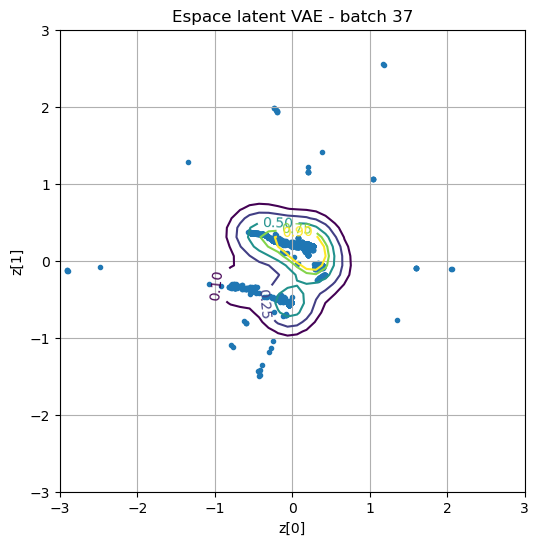

Process batch 38 de 2000 lignes
traite ligne 2000 du batch 38
entraîne VAE sur batch 38 --------------
kl_loss : 0.13
loss : 0.46
reconstruction_loss : 0.33


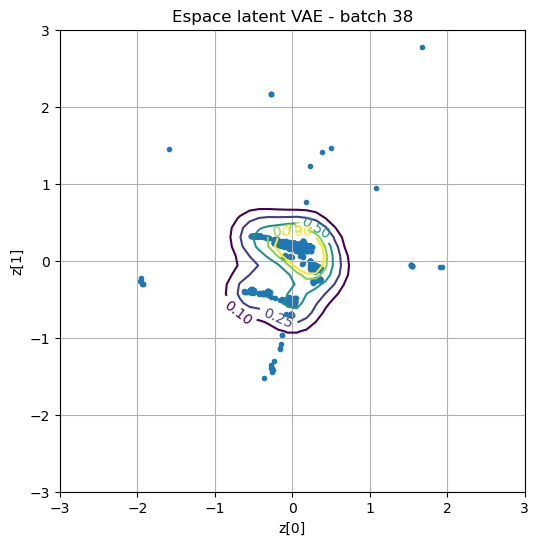

Process batch 39 de 2000 lignes
traite ligne 2000 du batch 39
entraîne VAE sur batch 39 --------------
kl_loss : 0.13
loss : 0.46
reconstruction_loss : 0.33


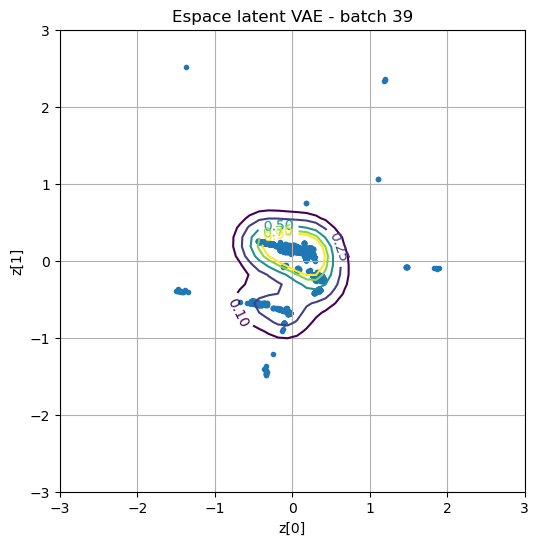

Process batch 40 de 2000 lignes
traite ligne 2000 du batch 40
entraîne VAE sur batch 40 --------------
kl_loss : 0.14
loss : 0.49
reconstruction_loss : 0.35


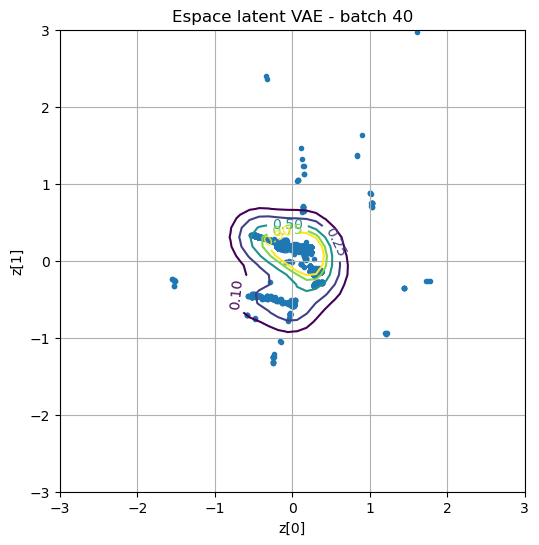

Process batch 41 de 2000 lignes
traite ligne 2000 du batch 41
entraîne VAE sur batch 41 --------------
kl_loss : 0.14
loss : 0.50
reconstruction_loss : 0.37


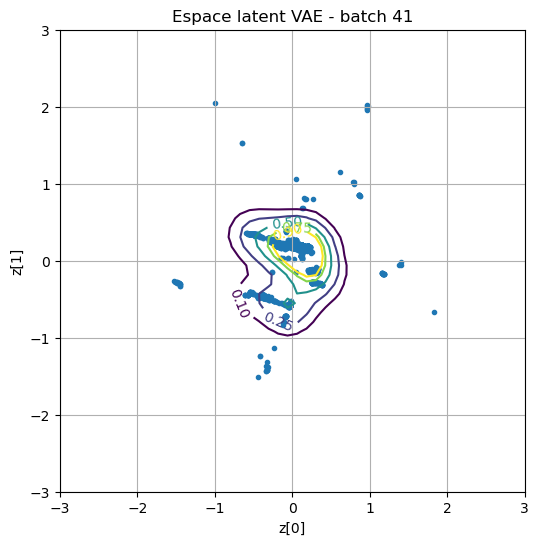

Process batch 42 de 2000 lignes
traite ligne 2000 du batch 42
entraîne VAE sur batch 42 --------------
kl_loss : 0.13
loss : 0.49
reconstruction_loss : 0.36


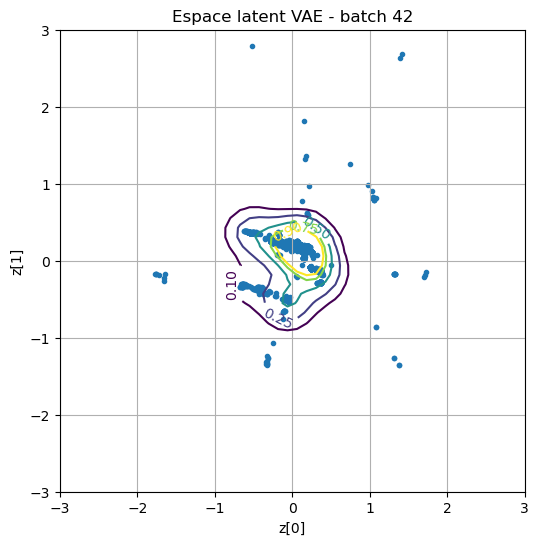

Process batch 43 de 2000 lignes
traite ligne 2000 du batch 43
entraîne VAE sur batch 43 --------------
kl_loss : 0.12
loss : 0.48
reconstruction_loss : 0.35


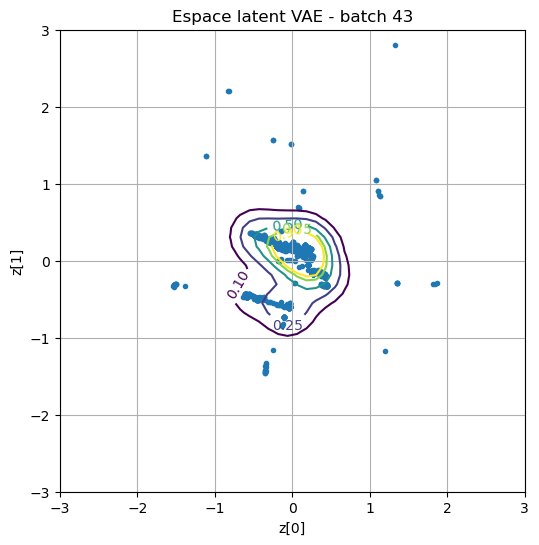

Process batch 44 de 2000 lignes
traite ligne 2000 du batch 44
entraîne VAE sur batch 44 --------------
kl_loss : 0.13
loss : 0.49
reconstruction_loss : 0.35


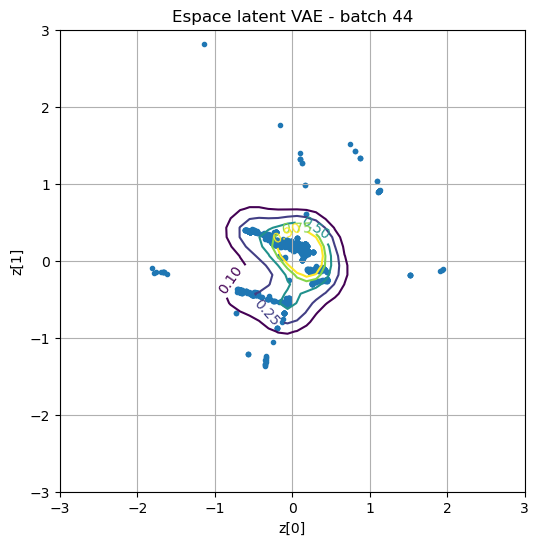

Process batch 45 de 2000 lignes
traite ligne 2000 du batch 45
entraîne VAE sur batch 45 --------------
kl_loss : 0.14
loss : 0.49
reconstruction_loss : 0.35


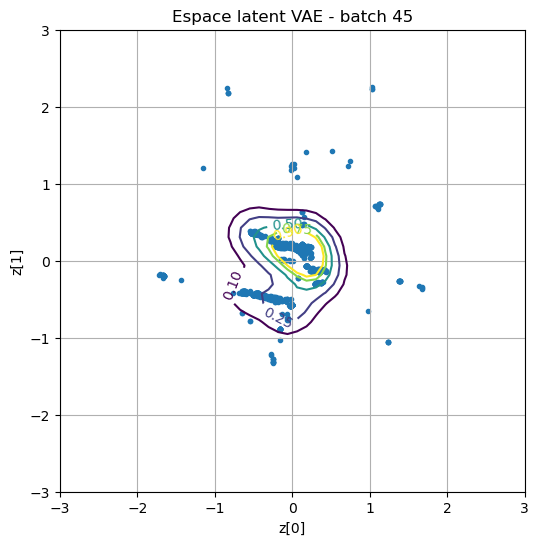

Process batch 46 de 2000 lignes
traite ligne 2000 du batch 46
entraîne VAE sur batch 46 --------------
kl_loss : 0.13
loss : 0.48
reconstruction_loss : 0.35


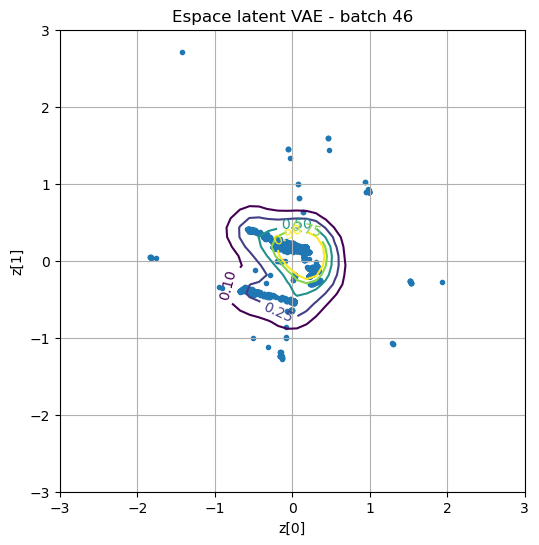

Process batch 47 de 2000 lignes
traite ligne 2000 du batch 47
entraîne VAE sur batch 47 --------------
kl_loss : 0.12
loss : 0.46
reconstruction_loss : 0.34


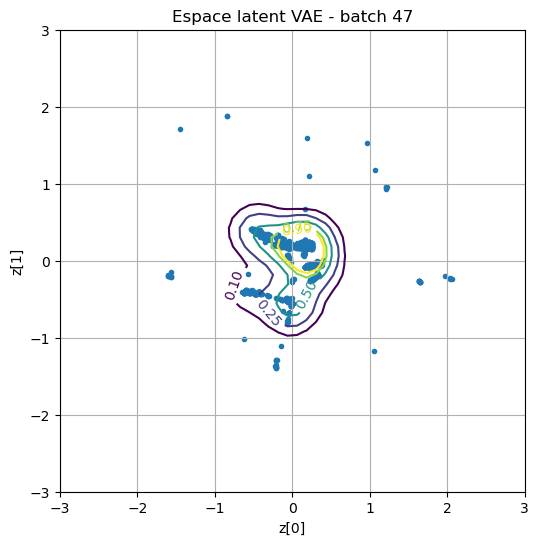

Process batch 48 de 2000 lignes
traite ligne 2000 du batch 48
entraîne VAE sur batch 48 --------------
kl_loss : 0.13
loss : 0.48
reconstruction_loss : 0.35


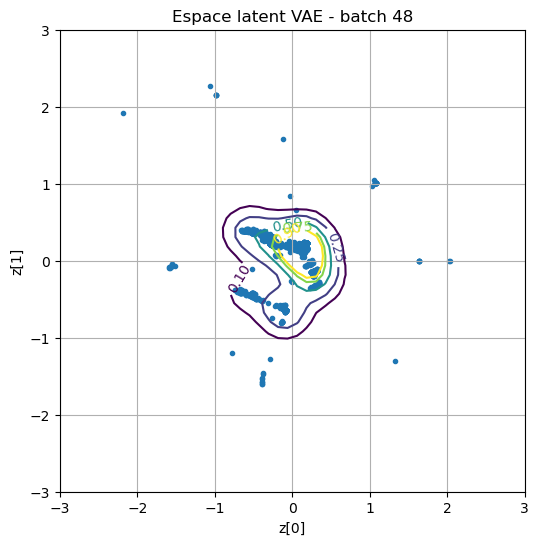

Process batch 49 de 2000 lignes
traite ligne 2000 du batch 49
entraîne VAE sur batch 49 --------------
kl_loss : 0.14
loss : 0.48
reconstruction_loss : 0.34


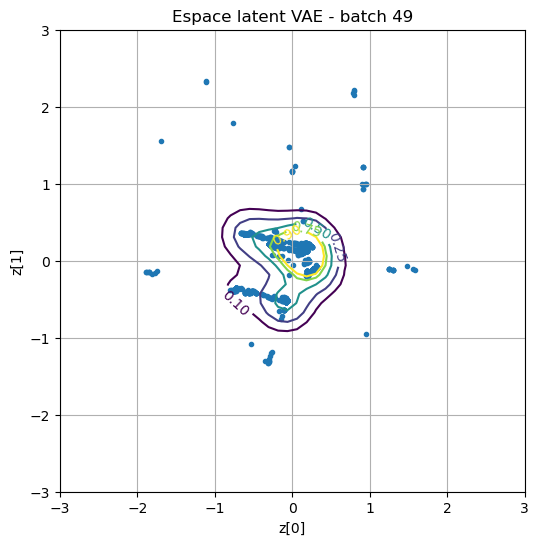

Process batch 50 de 2000 lignes
traite ligne 1951 du batch 50
entraîne VAE sur batch 50 --------------
kl_loss : 0.14
loss : 0.47
reconstruction_loss : 0.33


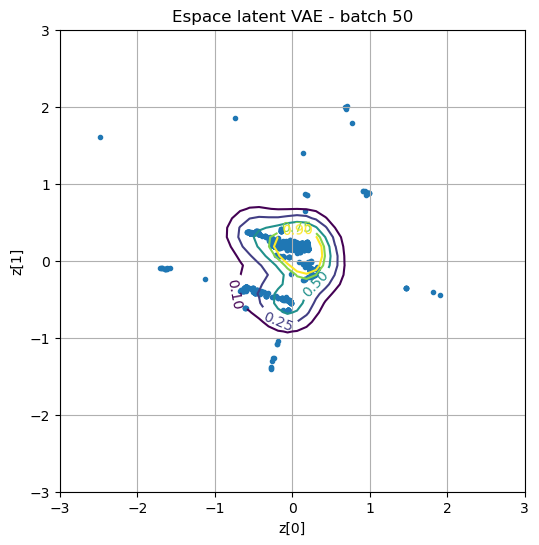

CPU times: user 49min 39s, sys: 3min 13s, total: 52min 52s
Wall time: 52min 52s


In [19]:
%%time

# Boucle training

# --- annonce la couleur
print(f"Processe {filename}\n")

# --- boucle
with open(file=filepath) as f:
    
    ctr_lines_total = 0
    ctr_batch = 1
    line = f.readline()
    
    while line != "":
        print(f"Process batch {ctr_batch} de {BATCH_SIZE} lignes")
        ctr_lines_in_batch = 0
        
        # --- inits pour le batch 
        # 1ere DataFrame : valeurs brutes (DEBUG ONLY)
        # dict_for_df_raw = { field : [] for field in list_fields }
        
        # 2e DataFrame : valeurs nettes
        dict_for_df = { field : [] for field in list_fields }
        
        # -- lit un batch, produit une DataFrame
        while (line != "") and (ctr_lines_in_batch<BATCH_SIZE):
            ctr_lines_in_batch += 1
            
            # - donne des nouvelles
            print(f"traite ligne {ctr_lines_in_batch} du batch {ctr_batch}", end="\r", flush=True)
            obj_json = json.loads(line)
            
            # - calcule à la main le UserNameDomainName
            obj_json['UserNameDomainName'] = obj_json.get('UserName') + obj_json.get('DomainName')
            
            # - trouve la valeur de chaque champ (éventuellement None) et traduit en categorical value suivant dictionnaire dico
            for field in list_fields:
                val = obj_json.get(field, None)
                # dict_for_df_raw[field].append(val)
                dict_for_df[field].append(dico[field].get_field_categorical_value(val))
                
            # - ligne suivante
            line = f.readline()
            
        df = pd.DataFrame(dict_for_df)
        
        # -- training du VAE avec le nouveau batch
        points = df.to_numpy()
        print(f'\nentraîne VAE sur batch {ctr_batch} --------------')
        
        callback = tf.keras.callbacks.EarlyStopping(    # NB : il faut instancier le callback à chaque training
            monitor="loss",
            patience=10,
            restore_best_weights=True,
        )
        
        # scaling pour convergence VAE. Mais a priori différent par batch ! Hum.
        s = StandardScaler()
        points_red = s.fit_transform(points)
        
        history = vae.fit(points_red, epochs=1000, batch_size=32, callbacks=[callback], verbose=0)
        for o in list_outputs:
            val = history.history.get(o)[-1]
            print(f'{o} : {val:.2f}')
        
        # -- affiche projection du batch dans l'espace latent 
        titre = f'Espace latent VAE - batch {ctr_batch}'
        fig, ax = plot_label_clusters(vae, points_red, titre)
        savefig = video_rep + filename + f'_batch_{ctr_batch}.png'
        plt.savefig(savefig)
        plt.show()
        
        # -- prochain batch
        ctr_batch += 1
        line = f.readline()
        

In [ ]:
# pour faire une video :

# ffmpeg -r 1  -f image2 -s 640x640 -i wls_day-01_subset_nnnn.json_batch_%d.png -vcodec libx264 -crf 15 -pix_fmt yuv420p video.mp4

# -r : frames per second

# Variational Bayesian Gaussian Mixture

In [ ]:
N_RESPONSIBILITIES_MAX = min(10,int(N / 100))
print(f'Max = {N_RESPONSIBILITIES_MAX} components')

In [ ]:
dpbgm = BayesianGaussianMixture(
    n_components = N_RESPONSIBILITIES_MAX, # max number of components, will be infered by data
    weight_concentration_prior_type = 'dirichlet_process',   # weight concentration prior is Dirchlet process : (approximate) infinite number of components
    random_state = 42,
    # reg_covar = 1e-6,
    verbose = 3,
    max_iter = 1000,
)

In [ ]:
dpbgm.fit(df.to_numpy())

In [ ]:
comp_number = [ x for x in range(N_RESPONSIBILITIES_MAX) ]
responsibilities = sorted(list(dpbgm.weights_),reverse=True)

fig, ax = plt.subplots(figsize=(20,6))
ax.bar(comp_number, responsibilities)
ax.set_xlabel('component number')
ax.set_ylabel('component weight')
ax.set_yscale("log")
ax.set_title(f'Bayesian MM responsibilities')
plt.show()

In [ ]:
# get responsibilities per point
probas = dpbgm.predict_proba(df.to_numpy())

# get predicted label, and associated responsibility, per data point
labels = np.argmax(probas, axis=1)
certainty = np.max(probas, axis=1)

In [ ]:
# 3D display of Bayesian GMM - projected points on PCA manifold
# if CHOICE=='lineaire':
#     pca = PCA(n_components=3)
# else:
#     pca = KernelPCA(n_components=3, kernel='rbf', gamma=5.0)
    
# X_red = pca.fit_transform(df)

X_red = pca3d.transform(df)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

# invoke color map
cmap = plt.cm.viridis

# create normalizing object to map labels values into color map
vmin = np.min(certainty)
vmax = np.max(certainty)
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False)

# instantiate 3d object
p = ax.scatter(X_red[:,0], X_red[:,1], X_red[:,2], c=cmap(norm(certainty)), marker='o') # 
ax.set_title(f'Bayesian GMM responsibility of affected gaussian, \nmixture of maximum {N_RESPONSIBILITIES_MAX} gaussians,\n 3D PCA projection - {N} points')
ax.set_xlabel('vp_1')
ax.set_ylabel('vp_2')
ax.set_zlabel('vp_3')

# display color map
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(p, ax=ax)

plt.show()

In [ ]:
# 3D display of Bayesian GMM - projected points on PCA manifold
# if CHOICE=='lineaire':
#     pca = PCA(n_components=3)
# else:
#     pca = KernelPCA(n_components=3, kernel='rbf', gamma=5.0)
    
# X_red = pca.fit_transform(df)

X_red = pca3d.transform(df)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

# invoke color map
cmap = plt.cm.viridis

# create normalizing object to map labels values into color map
vmin = np.min(labels)
vmax = np.max(labels)
# norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False)

# instantiate 3d object
p = ax.scatter(X_red[:,0], X_red[:,1], X_red[:,2], c=labels, marker='o') # 
ax.set_title(f'Bayesian GMM labels of affected gaussian, \nmixture of maximum {N_RESPONSIBILITIES_MAX} gaussians,\n 3D PCA projection - {N} points')
ax.set_xlabel('vp_1')
ax.set_ylabel('vp_2')
ax.set_zlabel('vp_3')

# display color map
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(p, ax=ax)

plt.show()

# One Class SVM

In [ ]:
latent_points = vae.encoder.predict(s.transform(points))[0]  # récupére les z_mean samplées dns l'espace latent de dim 2.

In [ ]:
latent_points

In [ ]:
clf = OneClassSVM(kernel='rbf', gamma='scale').fit(latent_points)  # classifier dans l'espace latent dim 2

In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay

# fig, ax = display_dataset(points, labels, mus, covs, sigma_max)

fig, ax = plt.subplots(figsize=(6,6))

DecisionBoundaryDisplay.from_estimator(
    estimator=clf,
    X=latent_points,
    response_method="predict",
    plot_method="contour",
    levels=[0,1,2,3,4,5],
    ax=ax
)

ax.scatter(latent_points[:,0], latent_points[:,1], marker='.')

ax.set_title('OC SVM')
ax.grid(True)

plt.show()